In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

In [ ]:
!unzip animals10.zip -d animals10

In [6]:
import os
from PIL import Image
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Plot class distribution

<ipython-input-7-0ff901a63d33>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


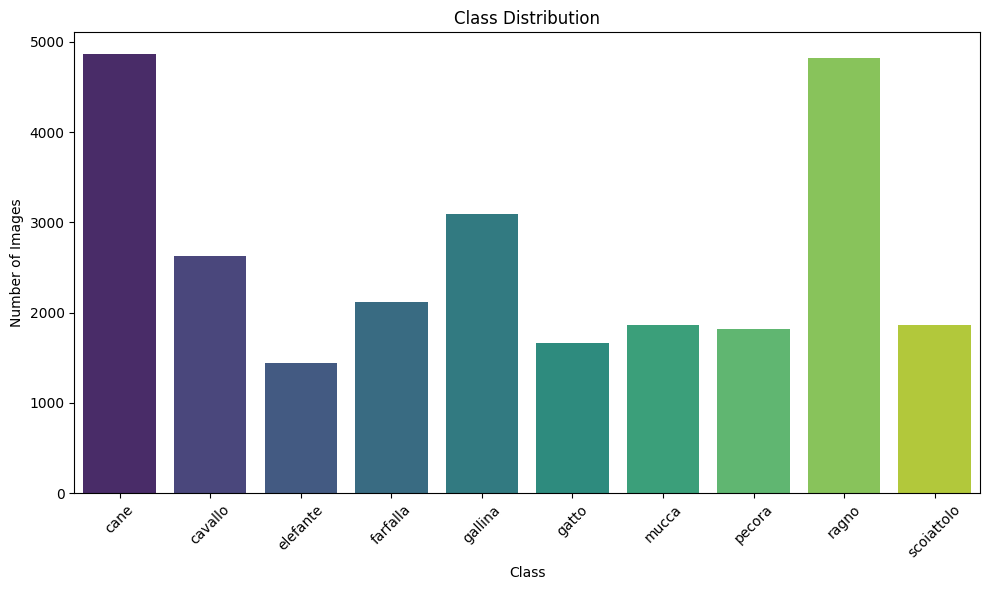

In [7]:
dataset_path = '/content/animals10/raw-img'

# Get list of classes (folder names)
class_names = sorted(os.listdir(dataset_path))

# Count images in each class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names}

# --- Plot class distribution ---
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Show 2 sample images from each class

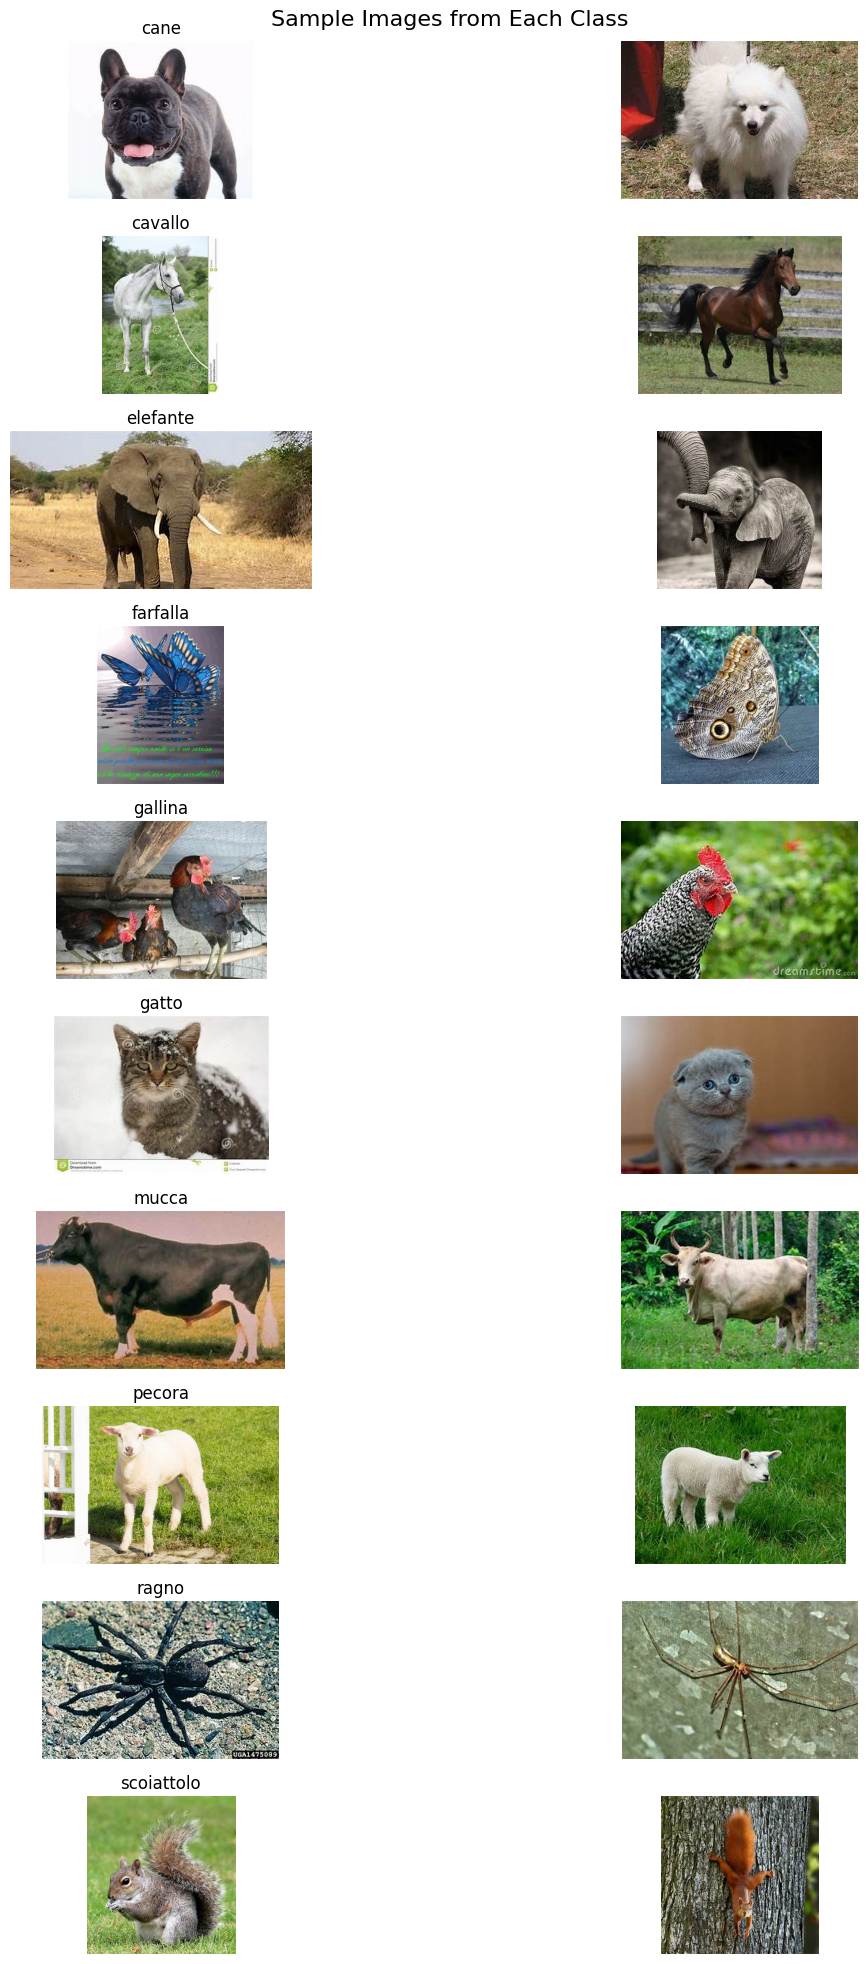

In [10]:
num_samples = 2
plt.figure(figsize=(15, len(class_names) * 2))

for i, cls in enumerate(class_names):
    class_dir = os.path.join(dataset_path, cls)
    sample_images = random.sample(os.listdir(class_dir), num_samples)

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 0:
            plt.title(cls)

plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

## Data Generator

In [12]:
batch_size = 32
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.15)

train_generator = datagen.flow_from_directory(dataset_path,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='training')

validation_generator = datagen.flow_from_directory(dataset_path,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    subset='validation')

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


## ConvNet Model (Pretrained VGG-16)
* Finetune the entire network
* Imagenet contains various animal images, so the network has already learnt features related to animals
* Keep the learning rate as small as possible because the new trained weights should be close the weights previously learnt to identify features of this use case

### Model Definition and Hyperparameter Settings

In [13]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

last = base_model.layers[-2].output
x = GlobalAveragePooling2D()(last)
x = Dense(512,'relu')(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 14,982,474 (57.15 MB)

 Non-trainable params: 0 (0.00 B)

### Model Checkpoints
- Reduce the learning rate if the validation loss does not decrease after 3 successive epochs
- Stop the training if the validation loss does not decrease after 5 successive epochs
- Save the best model if it has a better validation loss than before

In [14]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

### Model Training

In [15]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.6058 - loss: 1.1653
Epoch 1: val_loss improved from inf to 0.42569, saving model to model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 510s 679ms/step - accuracy: 0.6060 - loss: 1.1648 - val_accuracy: 0.8626 - val_loss: 0.4257 - learning_rate: 1.0000e-04
Epoch 2/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8703 - loss: 0.4119
Epoch 2: val_loss did not improve from 0.42569
696/696 ━━━━━━━━━━━━━━━━━━━━ 433s 622ms/step - accuracy: 0.8703 - loss: 0.4119 - val_accuracy: 0.8654 - val_loss: 0.4428 - learning_rate: 1.0000e-04
Epoch 3/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9018 - loss: 0.3110
Epoch 3: val_loss improved from 0.42569 to 0.31028, saving model to model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 437s 627ms/step - accuracy: 0.9018 - loss: 0.3110 - val_accuracy: 0.8975 - val_loss: 0.3103 - learning_rate: 1.0000e-04
Epoch 4/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9255 - loss: 0.2314
Epoch 4: val_loss did not improve from 0.31028
696/696 ━━━━━━━━━━━━━━━━━━━━ 438s 629ms/step - accuracy: 0.9255 - loss: 0.2315 - val_accuracy: 0.8881 - val_loss: 0.3444 - learning_rate: 1.0000e-04
Epoch 5/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9301 - loss: 0.2225
Epoch 5: val_loss improved from 0.31028 to 0.22999, saving model to model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 432s 621ms/step - accuracy: 0.9301 - loss: 0.2225 - val_accuracy: 0.9296 - val_loss: 0.2300 - learning_rate: 1.0000e-04
Epoch 6/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9414 - loss: 0.1854
Epoch 6: val_loss improved from 0.22999 to 0.21389, saving model to model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 430s 617ms/step - accuracy: 0.9414 - loss: 0.1854 - val_accuracy: 0.9296 - val_loss: 0.2139 - learning_rate: 1.0000e-04
Epoch 7/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9481 - loss: 0.1648
Epoch 7: val_loss improved from 0.21389 to 0.14848, saving model to model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 430s 617ms/step - accuracy: 0.9481 - loss: 0.1648 - val_accuracy: 0.9533 - val_loss: 0.1485 - learning_rate: 1.0000e-04
Epoch 8/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9511 - loss: 0.1525
Epoch 8: val_loss did not improve from 0.14848
696/696 ━━━━━━━━━━━━━━━━━━━━ 448s 626ms/step - accuracy: 0.9511 - loss: 0.1525 - val_accuracy: 0.9322 - val_loss: 0.2197 - learning_rate: 1.0000e-04
Epoch 9/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9563 - loss: 0.1402
Epoch 9: val_loss did not improve from 0.14848
696/696 ━━━━━━━━━━━━━━━━━━━━ 434s 623ms/step - accuracy: 0.9563 - loss: 0.1402 - val_accuracy: 0.9125 - val_loss: 0.2761 - learning_rate: 1.0000e-04
Epoch 10/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9590 - loss: 0.1322
Epoch 10: val_loss did not improve from 0.14848

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
696/696 ━━━━━━━━━━━━━━━━━━━━ 434s 624ms/step - accuracy: 0.9590 - l

696/696 ━━━━━━━━━━━━━━━━━━━━ 462s 663ms/step - accuracy: 0.9837 - loss: 0.0547 - val_accuracy: 0.9561 - val_loss: 0.1476 - learning_rate: 2.0000e-05
Epoch 12/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9893 - loss: 0.0352
Epoch 12: val_loss improved from 0.14761 to 0.14051, saving model to model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 431s 619ms/step - accuracy: 0.9893 - loss: 0.0352 - val_accuracy: 0.9600 - val_loss: 0.1405 - learning_rate: 2.0000e-05
Epoch 13/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9897 - loss: 0.0322
Epoch 13: val_loss improved from 0.14051 to 0.13220, saving model to model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 433s 621ms/step - accuracy: 0.9897 - loss: 0.0322 - val_accuracy: 0.9612 - val_loss: 0.1322 - learning_rate: 2.0000e-05
Epoch 14/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9922 - loss: 0.0256
Epoch 14: val_loss did not improve from 0.13220
696/696 ━━━━━━━━━━━━━━━━━━━━ 428s 615ms/step - accuracy: 0.9922 - loss: 0.0256 - val_accuracy: 0.9569 - val_loss: 0.1597 - learning_rate: 2.0000e-05
Epoch 15/15
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9926 - loss: 0.0276
Epoch 15: val_loss did not improve from 0.13220
696/696 ━━━━━━━━━━━━━━━━━━━━ 429s 616ms/step - accuracy: 0.9926 - loss: 0.0276 - val_accuracy: 0.9567 - val_loss: 0.1539 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 13.


### Learning Curves

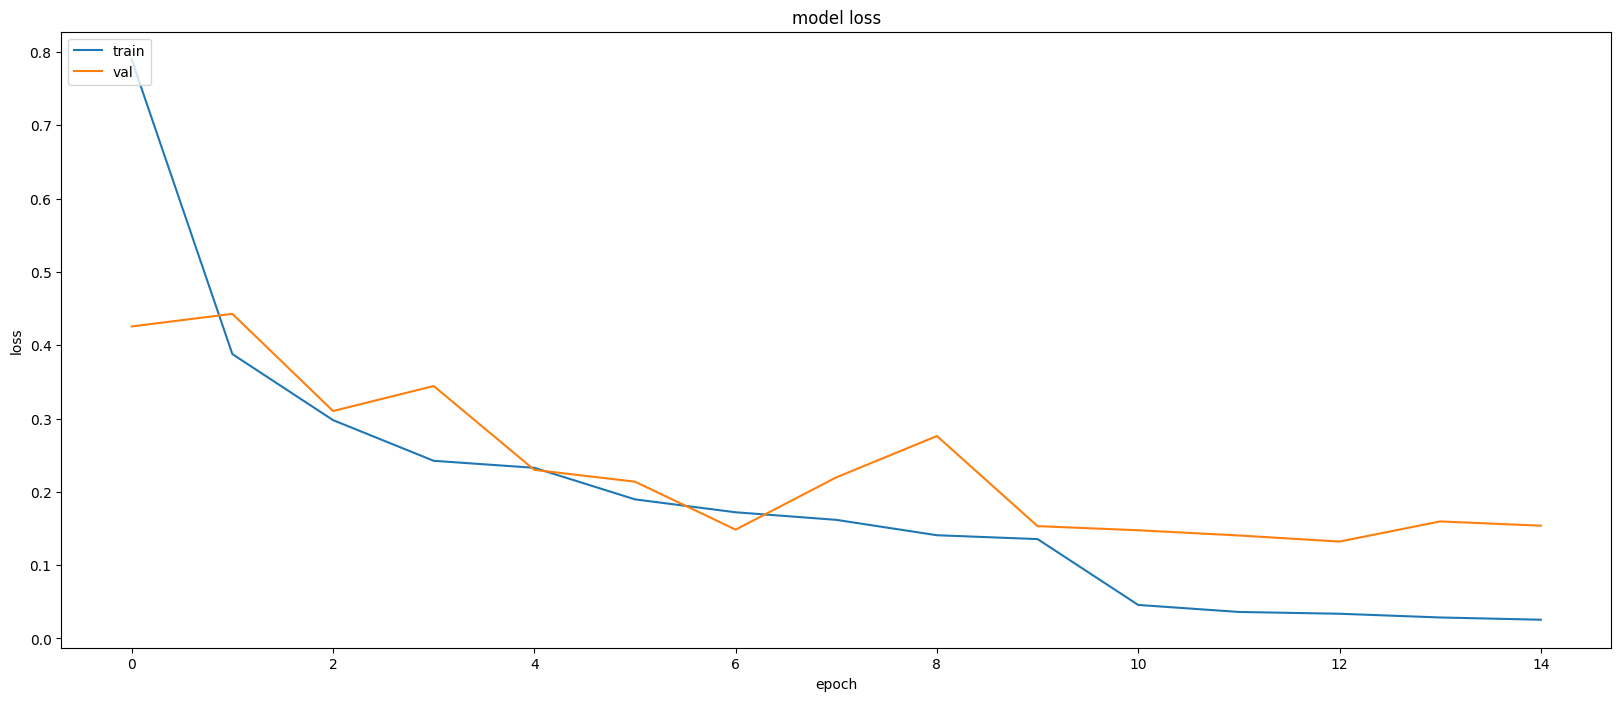

In [16]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

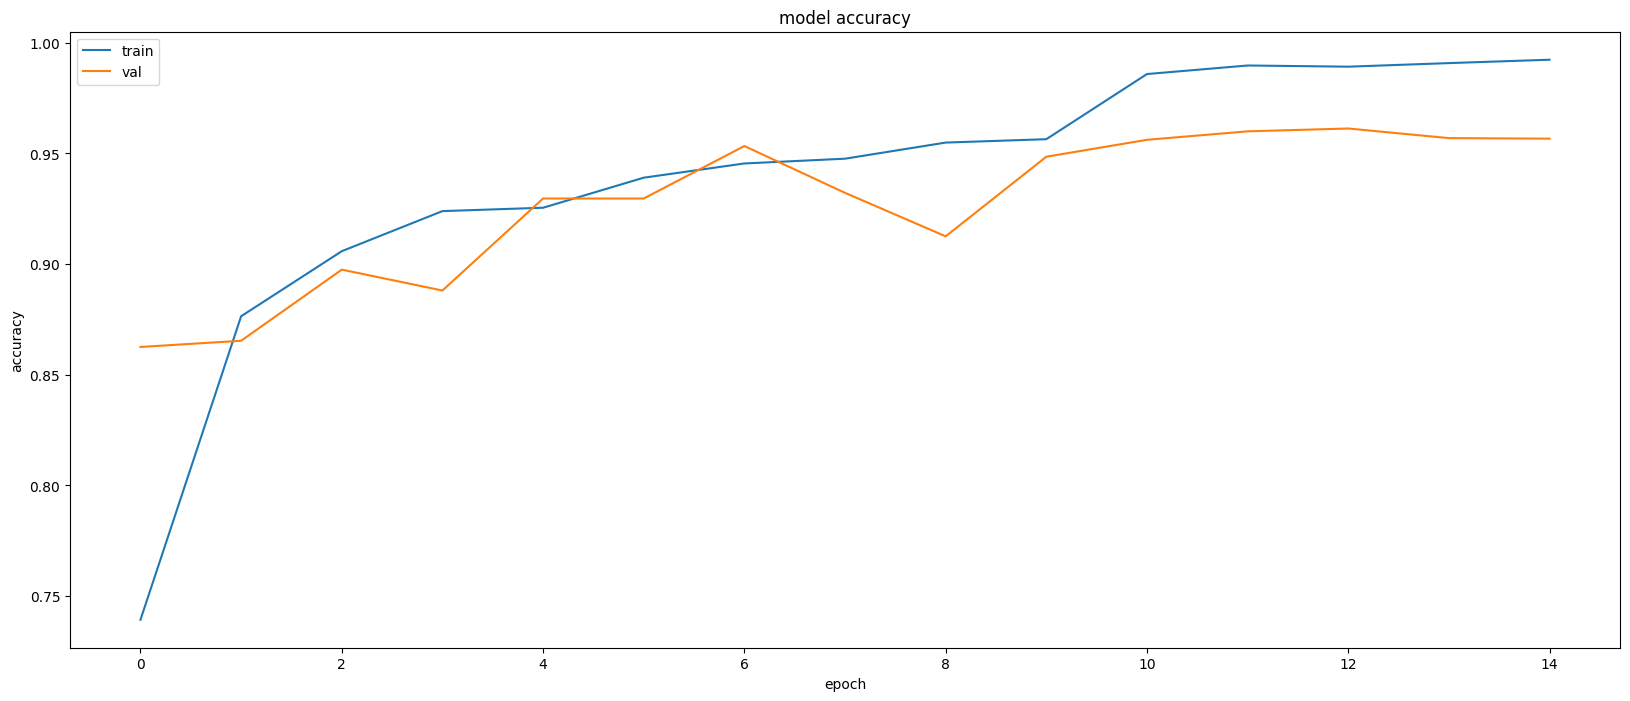

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Evalutation

In [18]:
from sklearn.metrics import classification_report

In [19]:
y_val = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

123/123 ━━━━━━━━━━━━━━━━━━━━ 51s 410ms/step


In [20]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       729
           1       0.96      0.96      0.96       393
           2       0.93      0.97      0.95       216
           3       0.98      0.93      0.96       316
           4       0.97      0.98      0.97       464
           5       0.98      0.95      0.96       250
           6       0.90      0.95      0.92       279
           7       0.97      0.87      0.92       273
           8       0.96      0.99      0.97       723
           9       0.97      0.92      0.94       279

    accuracy                           0.96      3922
   macro avg       0.96      0.95      0.95      3922
weighted avg       0.96      0.96      0.96      3922



In [21]:
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [22]:
filenames = validation_generator.filenames

In [23]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

filename actual predicted   Same
0      cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg   cane      cane   True
1  cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg   cane      cane   True
2  cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg   cane  elefante  False
3  cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg   cane      cane   True
4  cane/OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg   cane      cane   True
5  cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg   cane      cane   True
6  cane/OIP--0C2kq6I68beB3DduLoxMgHaEf.jpeg   cane      cane   True
7  cane/OIP--0CZnfLuBERVtzRm2QbB3gHaK4.jpeg   cane      cane   True
8  cane/OIP--1QXriWyOTJg-9fEwbznmgHaI4.jpeg   cane      cane   True
9  cane/OIP--2uTtzjaszBfEMCROuLN3wHaLH.jpeg   cane      cane   True

In [24]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

### Image Visualization
- Correctly Classified (A and P are same)
- Misclassified (A and P are different)
- A: Actual P: Predicted

In [28]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"{dataset_path}/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

### Correctly Classified

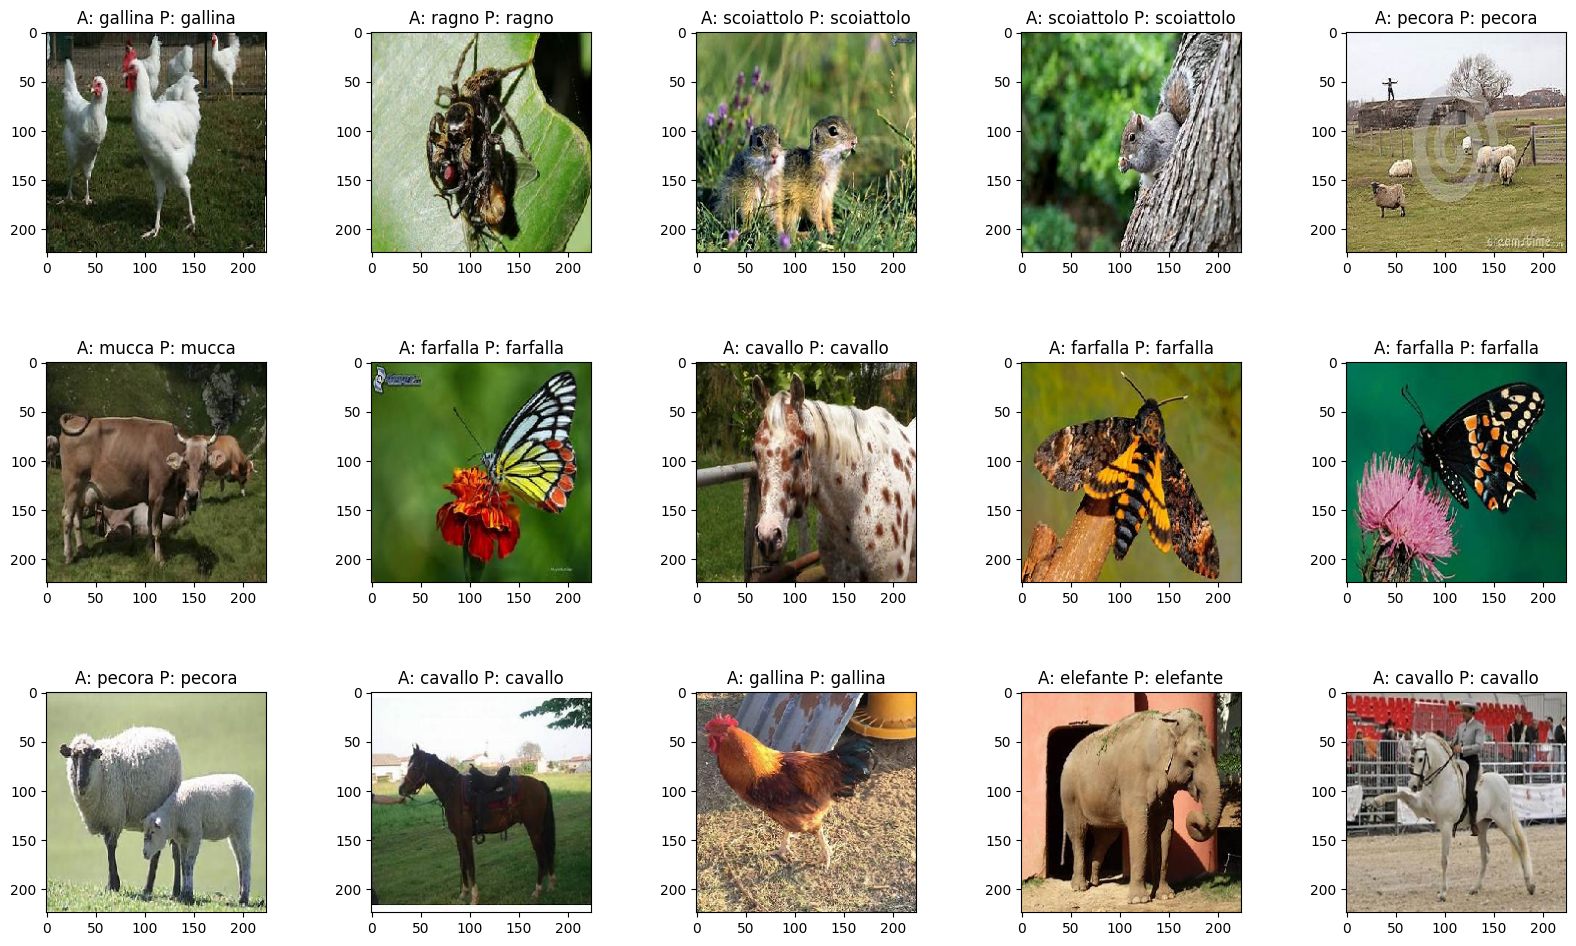

In [29]:
display_images(val_df[val_df['Same']==True])

### Misclassified

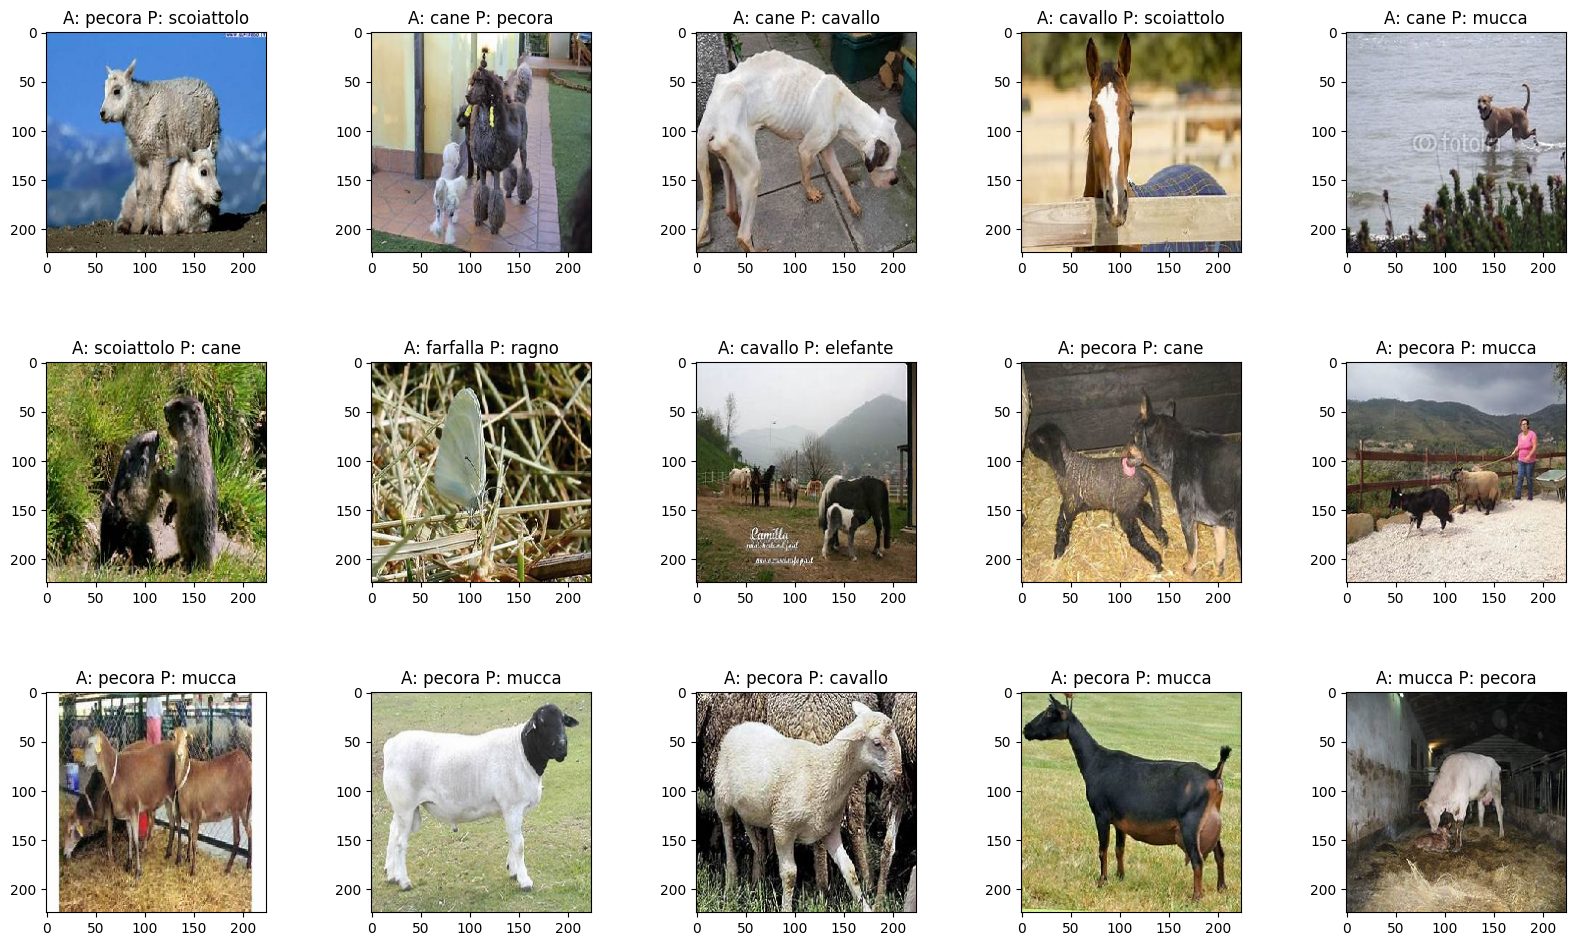

In [30]:
display_images(val_df[val_df['Same']!=True])

### Grad-CAM Computation
- Gradient computed of the final softmax layer with respect to the last convolution layer
- The fourth last layer of our model is the final convolutional block in our VGG-16 finetuned architecture
- Mean of the gradients is then multiplied to the last convolution layer's output
- The output is then passed through a relu function to ensure that all values are positive

In [31]:
def make_gradcam_heatmap(img_array, model, pred_index=None):

    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-4].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [32]:
import matplotlib.cm as cm

In [33]:
val_df

filename      actual   predicted  \
0                                   gallina/713.jpeg     gallina     gallina   
1          ragno/OIP-5IlPwpuxXOLBMxytTRS-uAHaE7.jpeg       ragno       ragno   
2     scoiattolo/OIP-2IKF9PpTCdZqnyq3sr-W-gHaFA.jpeg  scoiattolo  scoiattolo   
3     scoiattolo/OIP-7Z9WuPzGhB2TMIlprNrFHQHaE7.jpeg  scoiattolo  scoiattolo   
4         pecora/OIP-6C5nwq1T5MedRXEqyuvQrQAAAA.jpeg      pecora      pecora   
...                                              ...         ...         ...   
3917        cane/OIP-5LiaFBwI-7ArCS72EMghIgHaF7.jpeg        cane        cane   
3918       ragno/OIP-4naMsRQTmYjJVJLu-VpJ6AHaFf.jpeg       ragno       ragno   
3919       ragno/OIP-660c3Ul-LhsB9zKof7NJvgHaJK.jpeg       ragno       ragno   
3920        cane/OIP-1Q_r1kaGmFXYAkd28zlJvwHaFj.jpeg        cane        cane   
3921     cavallo/OIP-6EMRqs8pzeT8xwPWjVjpAwHaFs.jpeg     cavallo     cavallo   

      Same  
0     True  
1     True  
2     True  
3     True  
4     True  
...    ...  
3917  True  
3918  True  
3919  True  
3920  True  
3921  True  

[3922 rows x 4 columns]

### Grad-CAM Projection
- The heatmap produced using the Grad-CAM computation is then projected on to the original image
- The heatmap highlights the important parts of the image that lead to the activation of a class in the final softmax layer

In [34]:
def gradCAMImage(image):
    path = f"{dataset_path}/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

## Results

In [35]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = val_df[val_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(15):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [ ]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

In [37]:
def display_heatmaps(classified_images,titles):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

### Grad-CAM: Correctly Classified

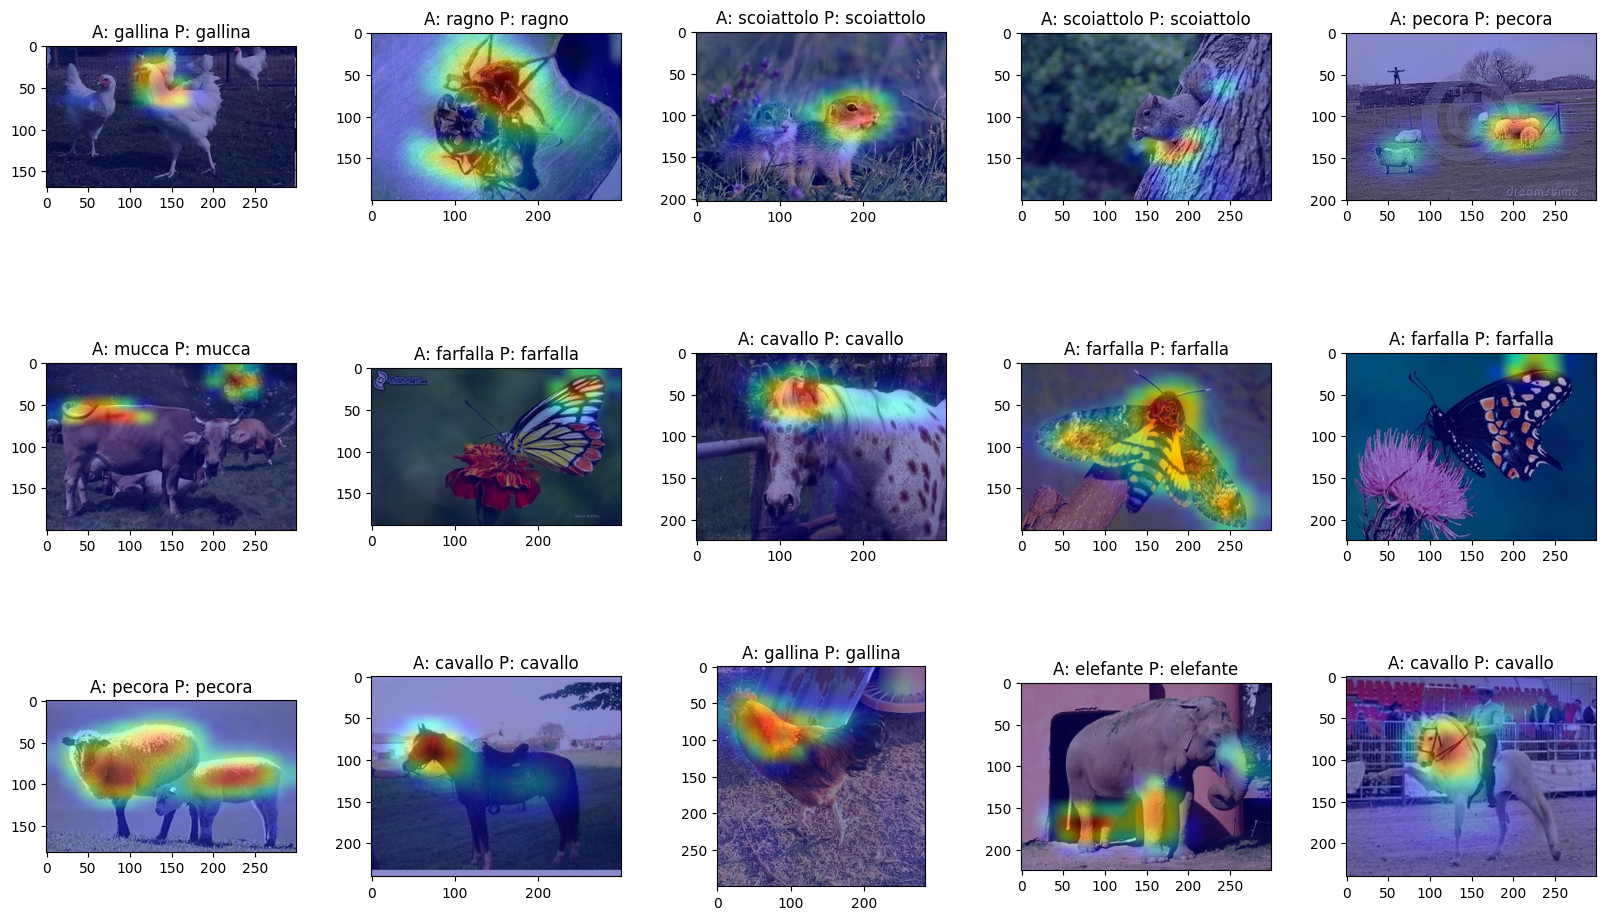

In [38]:
display_heatmaps(correctly_classified,c_titles)

**Inference:** As it can be seen some important features of the animals are highlighted in the image
- Mouth of a dog
- Fluffy woolen body of a sheep
- Legs and body of a spider
- Mouth of a squirrel
- Head of a horse
- etc.

### Grad-CAM: Incorrectly Classified

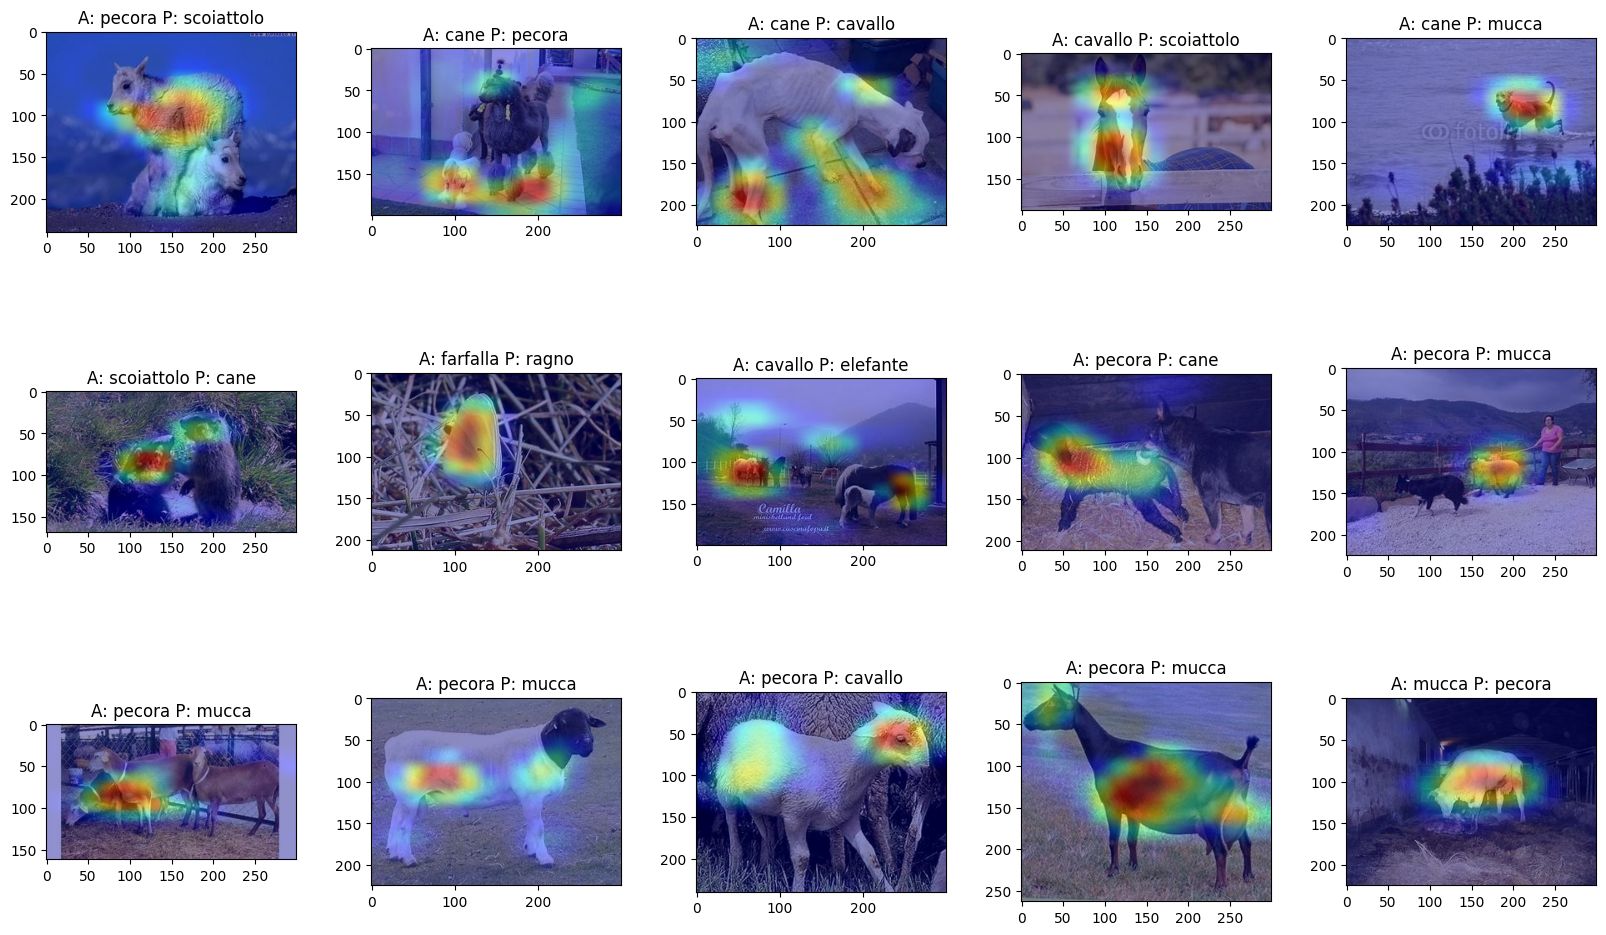

In [39]:
display_heatmaps(misclassified,m_titles)

**Inference:** As it can be seen some features have been incorrectly detected on some of these animal pictures either due to the positioning of the animal in the image or due to the orientation of the image
e.g.
- Distant image of a Pomerian breed dog is misinterpretted as chicken due to its small size
- Furry cat in the distance is misinterpretted as a sheep
- Body of animals like sheep and horse are being misinterpretted as cow due to the sideways orientation of the animal in the image
- A close up sideways picture of a furry dog is misinterpretted as sheep
- etc.
